In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

# LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib
import os

print("✅ Libraries loaded!")

# Load data
print("\nLoading processed data...")
sales_sample = pd.read_csv('../data/processed/sales_with_features_sample.csv')
sales_sample['date'] = pd.to_datetime(sales_sample['date'])
segments = pd.read_csv('../data/processed/products_segmented.csv')

print(f"Sample shape: {sales_sample.shape}")
print(f"Unique products: {sales_sample['id'].nunique()}")
print(f"Date range: {sales_sample['date'].min()} to {sales_sample['date'].max()}")
print("\n✅ Data loaded!")

✅ Libraries loaded!

Loading processed data...
Sample shape: (191300, 51)
Unique products: 100
Date range: 2011-01-29 00:00:00 to 2016-04-24 00:00:00

✅ Data loaded!


In [7]:
print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

# Use last 28 days as test set
test_days = 28
cutoff_date = sales_sample['date'].max() - timedelta(days=test_days)

print(f"Total days in dataset: {sales_sample['date'].nunique()}")
print(f"Cutoff date: {cutoff_date}")
print(f"Train period: {sales_sample['date'].min()} to {cutoff_date}")
print(f"Test period: {cutoff_date} to {sales_sample['date'].max()}")

# Split data (KEEP ALL COLUMNS!)
train_df = sales_sample[sales_sample['date'] <= cutoff_date].copy()
test_df = sales_sample[sales_sample['date'] > cutoff_date].copy()

print(f"\nTrain size: {len(train_df):,} rows")
print(f"Test size: {len(test_df):,} rows")
print(f"Split ratio: {len(train_df)/len(sales_sample)*100:.1f}% train / {len(test_df)/len(sales_sample)*100:.1f}% test")

# Verify 'id' column exists
print(f"\n✅ Checking columns...")
print(f"Train columns: {len(train_df.columns)}")
print(f"Test columns: {len(test_df.columns)}")

# Show key columns
key_cols = ['id', 'date', 'sales', 'sold_lag_7', 'rolling_mean_7']
available_key_cols = [col for col in key_cols if col in train_df.columns]
print(f"\nKey columns present: {available_key_cols}")

# Verify products in test set
if 'id' in test_df.columns:
    print(f"\n✅ Products in test set: {test_df['id'].nunique()}")
else:
    print("\n❌ ERROR: 'id' column missing!")
    print("Available columns:", list(test_df.columns[:10]))

# Store results
results = []

TRAIN/TEST SPLIT
Total days in dataset: 1913
Cutoff date: 2016-03-27 00:00:00
Train period: 2011-01-29 00:00:00 to 2016-03-27 00:00:00
Test period: 2016-03-27 00:00:00 to 2016-04-24 00:00:00

Train size: 188,500 rows
Test size: 2,800 rows
Split ratio: 98.5% train / 1.5% test

✅ Checking columns...
Train columns: 51
Test columns: 51

Key columns present: ['id', 'date', 'sales', 'sold_lag_7', 'rolling_mean_7']

✅ Products in test set: 100


In [9]:
# Quick verification
print("Checking data integrity...")
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")
print(f"\nColumns in train_df: {list(train_df.columns[:15])}")
print(f"\nColumns in test_df: {list(test_df.columns[:15])}")
print(f"\n'id' in train_df: {'id' in train_df.columns}")
print(f"'id' in test_df: {'id' in test_df.columns}")

if 'id' in test_df.columns:
    print(f"\n✅ All good! Unique products in test: {test_df['id'].nunique()}")
else:
    print("\n❌ Still missing 'id' column!")

Checking data integrity...
train_df shape: (188500, 51)
test_df shape: (2800, 51)

Columns in train_df: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1']

Columns in test_df: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1']

'id' in train_df: True
'id' in test_df: True

✅ All good! Unique products in test: 100


In [3]:
def calculate_metrics(y_true, y_pred, product_id="Unknown"):
    """Calculate forecasting metrics"""
    
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 0)
    
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAPE (avoid division by zero)
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # Bias (mean error)
    bias = np.mean(y_pred - y_true)
    
    return {
        'product_id': product_id,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Bias': bias,
        'Mean_Actual': y_true.mean(),
        'Mean_Predicted': y_pred.mean()
    }

def plot_predictions(dates, y_true, y_pred, title, product_id):
    """Plot actual vs predicted"""
    plt.figure(figsize=(15, 5))
    plt.plot(dates, y_true, label='Actual', marker='o', linewidth=2)
    plt.plot(dates, y_pred, label='Predicted', marker='x', linewidth=2, alpha=0.7)
    plt.axvline(x=dates.iloc[0], color='red', linestyle='--', label='Test Start', alpha=0.5)
    plt.title(f'{title} - {product_id}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined!")

✅ Helper functions defined!


MODEL 1: BASELINE (7-Day Moving Average)

Baseline for: FOODS_1_049_TX_2_validation (1/5)
  MAE: 0.11
  RMSE: 0.21
  MAPE: 50.00%


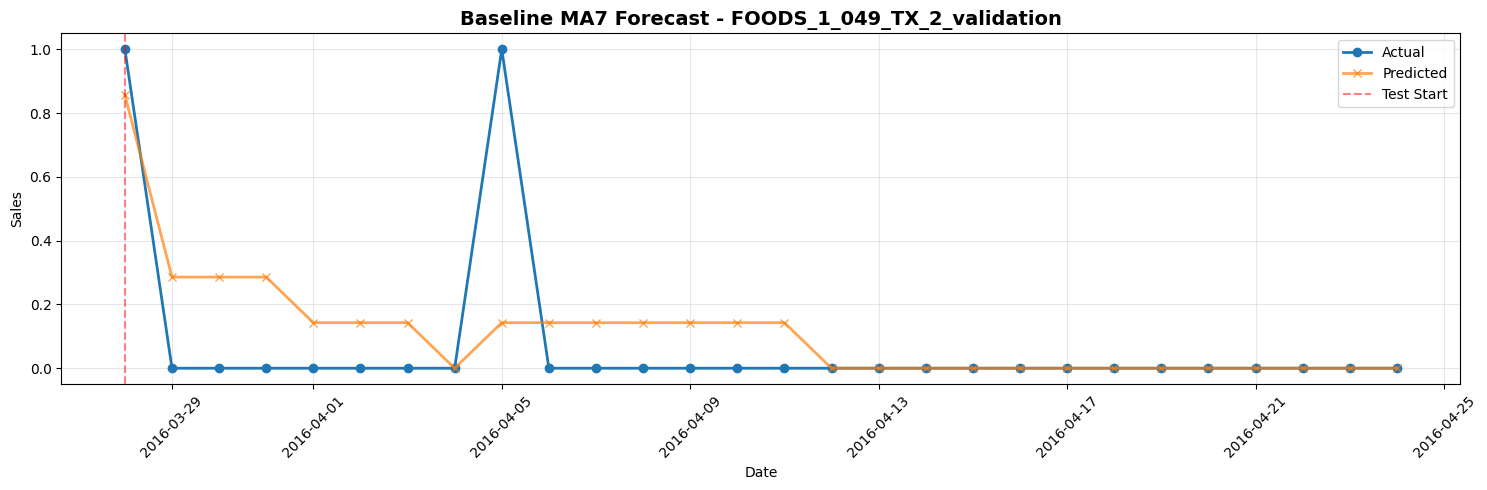


Baseline for: FOODS_1_079_CA_4_validation (2/5)
  MAE: 0.22
  RMSE: 0.39
  MAPE: 71.43%

Baseline for: FOODS_1_097_CA_2_validation (3/5)
  MAE: 0.94
  RMSE: 1.17
  MAPE: 42.18%

Baseline for: FOODS_2_052_WI_1_validation (4/5)
  MAE: 0.80
  RMSE: 1.01
  MAPE: 33.51%

Baseline for: FOODS_2_078_CA_4_validation (5/5)
  MAE: 0.73
  RMSE: 0.86
  MAPE: 44.20%

BASELINE SUMMARY
                 product_id      MAE     RMSE      MAPE
FOODS_1_049_TX_2_validation 0.112245 0.205607 50.000000
FOODS_1_079_CA_4_validation 0.224490 0.391230 71.428571
FOODS_1_097_CA_2_validation 0.943878 1.165278 42.180451
FOODS_2_052_WI_1_validation 0.795918 1.008708 33.511905
FOODS_2_078_CA_4_validation 0.734694 0.859690 44.196429

Average MAE: 0.56
Average RMSE: 0.73
Average MAPE: 48.26%

✅ Baseline model complete!


In [12]:
print("="*60)
print("MODEL 1: BASELINE (7-Day Moving Average)")
print("="*60)

# Simple baseline: Use 7-day moving average as prediction
sample_products = sales_sample['id'].unique()[:5]
prophet_results = []

for idx, product_id in enumerate(sample_products):
    print(f"\n{'='*50}")
    print(f"Baseline for: {product_id} ({idx+1}/{len(sample_products)})")
    print(f"{'='*50}")
    
    # Get product test data
    product_test = test_df[test_df['id'] == product_id].copy()
    
    if len(product_test) == 0:
        print(f"⚠️ Skipping {product_id} - no test data")
        continue
    
    # Use rolling_mean_7 as prediction
    y_true = product_test['sales'].values
    
    # Check if rolling_mean_7 exists
    if 'rolling_mean_7' in product_test.columns:
        y_pred = product_test['rolling_mean_7'].fillna(product_test['sales'].mean()).values
    else:
        # Fallback: use overall mean
        y_pred = np.full(len(y_true), product_test['sales'].mean())
    
    y_pred = np.maximum(y_pred, 0)
    
    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred, product_id)
    metrics['model'] = 'Baseline_MA7'
    prophet_results.append(metrics)
    
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    
    # Plot first product
    if idx == 0:
        plot_predictions(
            product_test['date'], 
            y_true, 
            y_pred,
            "Baseline MA7 Forecast",
            product_id
        )

# Summary
if len(prophet_results) > 0:
    prophet_df = pd.DataFrame(prophet_results)
    print(f"\n{'='*60}")
    print("BASELINE SUMMARY")
    print(f"{'='*60}")
    print(prophet_df[['product_id', 'MAE', 'RMSE', 'MAPE']].to_string(index=False))
    print(f"\nAverage MAE: {prophet_df['MAE'].mean():.2f}")
    print(f"Average RMSE: {prophet_df['RMSE'].mean():.2f}")
    print(f"Average MAPE: {prophet_df['MAPE'].mean():.2f}%")
else:
    prophet_df = pd.DataFrame(columns=['product_id', 'MAE', 'RMSE', 'MAPE', 'model'])

print("\n✅ Baseline model complete!")

In [13]:
print("="*60)
print("MODEL 2: LIGHTGBM (Main Production Model)")
print("="*60)

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features to use
feature_cols = [
    # Lag features
    'sold_lag_1', 'sold_lag_7', 'sold_lag_14', 'sold_lag_28',
    # Rolling features
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28',
    # Calendar features
    'day_sin', 'day_cos', 'is_weekend',
]

# Check which features exist in the data
available_features = [col for col in feature_cols if col in train_df.columns]
print(f"\n📊 Using {len(available_features)} features:")
for feat in available_features:
    print(f"  ✓ {feat}")

missing_features = [col for col in feature_cols if col not in train_df.columns]
if missing_features:
    print(f"\n⚠️ Missing features (will skip): {missing_features}")

target_col = 'sales'

# Prepare data
print(f"\n{'='*60}")
print("PREPARING DATA")
print(f"{'='*60}")

X_train = train_df[available_features].copy()
y_train = train_df[target_col].copy()
X_test = test_df[available_features].copy()
y_test = test_df[target_col].copy()

# Handle missing values
print(f"\nMissing values in train: {X_train.isnull().sum().sum()}")
print(f"Missing values in test: {X_test.isnull().sum().sum()}")

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"\n✅ After filling NaN:")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape: {X_test.shape}")

# Train LightGBM
print(f"\n{'='*60}")
print("TRAINING LIGHTGBM")
print(f"{'='*60}")

params = {
    'objective': 'tweedie',  # Good for retail sales (zero-inflated)
    'metric': 'rmse',
    'tweedie_variance_power': 1.1,  # Between Poisson and Gamma
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 8,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'seed': 42
}

print("\n⏳ Training model...")
print("Parameters:")
for key, val in params.items():
    print(f"  {key}: {val}")

# Create dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✅ Training complete!")
print(f"✅ Best iteration: {model_lgb.best_iteration}")
print(f"✅ Best RMSE: {model_lgb.best_score['test']['rmse']:.4f}")

# Predict
print(f"\n{'='*60}")
print("MAKING PREDICTIONS")
print(f"{'='*60}")

y_pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
y_pred_lgb = np.maximum(y_pred_lgb, 0)  # No negative sales

print(f"Predictions generated: {len(y_pred_lgb)}")
print(f"Prediction range: [{y_pred_lgb.min():.2f}, {y_pred_lgb.max():.2f}]")
print(f"Actual range: [{y_test.min():.2f}, {y_test.max():.2f}]")

# Overall metrics
lgb_metrics = calculate_metrics(y_test.values, y_pred_lgb, "All Products")
lgb_metrics['model'] = 'LightGBM'

print(f"\n{'='*60}")
print("LIGHTGBM OVERALL PERFORMANCE")
print(f"{'='*60}")
print(f"MAE:  {lgb_metrics['MAE']:.2f} units")
print(f"RMSE: {lgb_metrics['RMSE']:.2f} units")
print(f"MAPE: {lgb_metrics['MAPE']:.2f}%")
print(f"Bias: {lgb_metrics['Bias']:.2f} units")
print(f"\nMean Actual Sales: {lgb_metrics['Mean_Actual']:.2f}")
print(f"Mean Predicted Sales: {lgb_metrics['Mean_Predicted']:.2f}")

print("\n✅ LightGBM training complete!")

MODEL 2: LIGHTGBM (Main Production Model)

📊 Using 10 features:
  ✓ sold_lag_1
  ✓ sold_lag_7
  ✓ sold_lag_14
  ✓ sold_lag_28
  ✓ rolling_mean_7
  ✓ rolling_mean_14
  ✓ rolling_mean_28
  ✓ day_sin
  ✓ day_cos
  ✓ is_weekend

PREPARING DATA

Missing values in train: 5000
Missing values in test: 0

✅ After filling NaN:
   Train shape: (188500, 10)
   Test shape: (2800, 10)

TRAINING LIGHTGBM

⏳ Training model...
Parameters:
  objective: tweedie
  metric: rmse
  tweedie_variance_power: 1.1
  learning_rate: 0.05
  num_leaves: 31
  max_depth: 8
  min_child_samples: 20
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 0.1
  verbose: -1
  seed: 42
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.37391	test's rmse: 1.44077
Early stopping, best iteration is:
[110]	train's rmse: 1.36859	test's rmse: 1.43813

✅ Training complete!
✅ Best iteration: 110
✅ Best RMSE: 1.4381

MAKING PREDICTIONS
Predictions generated: 2800
Prediction range: [0.00

FEATURE IMPORTANCE ANALYSIS

📊 Top Features by Importance:
        feature   importance
 rolling_mean_7 2.880525e+06
rolling_mean_14 1.461771e+06
     sold_lag_1 3.609192e+04
        day_sin 3.266778e+04
rolling_mean_28 1.364120e+04
     sold_lag_7 5.658402e+03
    sold_lag_28 3.846049e+03
    sold_lag_14 1.980373e+03
     is_weekend 1.315631e+03
        day_cos 8.400569e+02


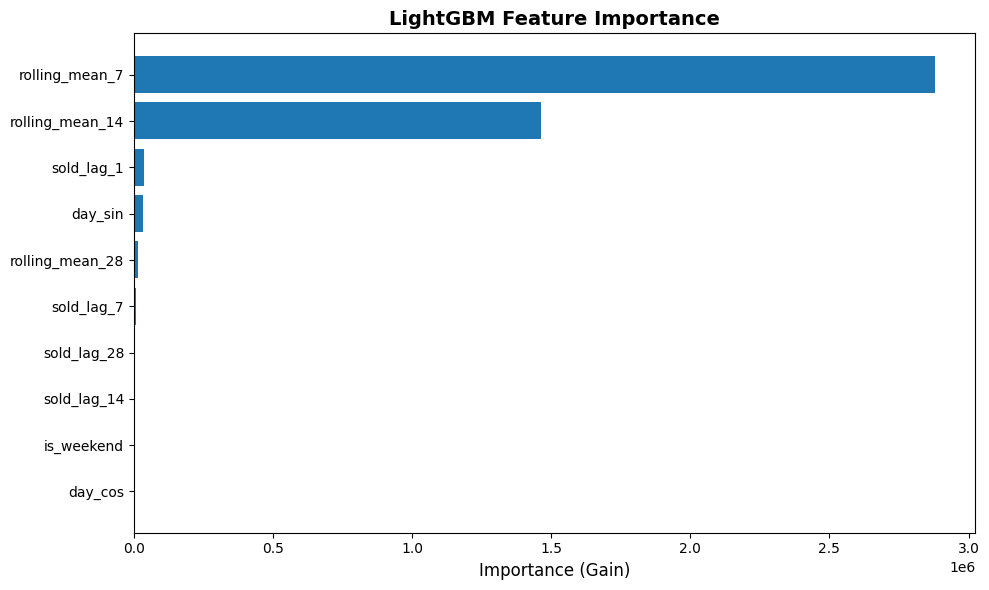


KEY INSIGHTS
🥇 Most important feature: rolling_mean_7
   Importance: 2880525

🥈 Second most important: rolling_mean_14
   Importance: 1461771

Top 3 features account for 98.6% of total importance


In [14]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance
importance = pd.DataFrame({
    'feature': available_features,
    'importance': model_lgb.feature_importance(importance_type='gain')
})
importance = importance.sort_values('importance', ascending=False)

print("\n📊 Top Features by Importance:")
print(importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance['importance'].values)
plt.yticks(range(len(importance)), importance['feature'].values)
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Key insights
print(f"\n{'='*60}")
print("KEY INSIGHTS")
print(f"{'='*60}")
print(f"🥇 Most important feature: {importance.iloc[0]['feature']}")
print(f"   Importance: {importance.iloc[0]['importance']:.0f}")
print(f"\n🥈 Second most important: {importance.iloc[1]['feature']}")
print(f"   Importance: {importance.iloc[1]['importance']:.0f}")

# Feature importance percentages
importance['percentage'] = (importance['importance'] / importance['importance'].sum()) * 100
print(f"\nTop 3 features account for {importance['percentage'].head(3).sum():.1f}% of total importance")

In [15]:
print("="*60)
print("PER-PRODUCT PERFORMANCE")
print("="*60)

# Get the sample products we used for baseline
sample_products = sales_sample['id'].unique()[:5]

# Calculate LightGBM metrics for each product
lgb_product_results = []

for product_id in sample_products:
    # Get test data for this product
    product_test_idx = test_df[test_df['id'] == product_id].index
    
    if len(product_test_idx) == 0:
        continue
    
    # Get predictions for this product
    # Find indices in the full test set
    test_positions = [i for i, idx in enumerate(test_df.index) if idx in product_test_idx]
    
    if len(test_positions) == 0:
        continue
    
    # Get actual and predicted values
    y_true = test_df.loc[product_test_idx, 'sales'].values
    y_pred = y_pred_lgb[test_positions]
    
    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred, product_id)
    metrics['model'] = 'LightGBM'
    lgb_product_results.append(metrics)

lgb_product_df = pd.DataFrame(lgb_product_results)

print("\n📊 LightGBM Performance by Product:")
print(lgb_product_df[['product_id', 'MAE', 'RMSE', 'MAPE']].to_string(index=False))

# Compare with baseline
if len(prophet_df) > 0:
    print(f"\n{'='*60}")
    print("BASELINE vs LIGHTGBM COMPARISON")
    print(f"{'='*60}")
    
    # Merge dataframes
    comparison_df = pd.concat([prophet_df, lgb_product_df], ignore_index=True)
    
    # Pivot for comparison
    comparison_pivot = comparison_df.pivot_table(
        index='product_id',
        columns='model',
        values=['MAE', 'RMSE', 'MAPE']
    )
    
    print("\n📊 Side-by-Side Comparison:")
    print(comparison_pivot)
    
    # Calculate improvement
    baseline_avg = prophet_df[['MAE', 'RMSE', 'MAPE']].mean()
    lgb_avg = lgb_product_df[['MAE', 'RMSE', 'MAPE']].mean()
    
    improvement_mae = ((baseline_avg['MAE'] - lgb_avg['MAE']) / baseline_avg['MAE']) * 100
    improvement_rmse = ((baseline_avg['RMSE'] - lgb_avg['RMSE']) / baseline_avg['RMSE']) * 100
    improvement_mape = ((baseline_avg['MAPE'] - lgb_avg['MAPE']) / baseline_avg['MAPE']) * 100
    
    print(f"\n{'='*60}")
    print("🎯 LIGHTGBM IMPROVEMENT vs BASELINE")
    print(f"{'='*60}")
    print(f"MAE improved by:  {improvement_mae:.1f}%")
    print(f"RMSE improved by: {improvement_rmse:.1f}%")
    print(f"MAPE improved by: {improvement_mape:.1f}%")
    
    if improvement_mae > 0:
        print(f"\n✅ LightGBM is BETTER by {improvement_mae:.1f}%!")
    else:
        print(f"\n⚠️ Baseline performed better (unusual - check data)")
else:
    comparison_df = lgb_product_df.copy()
    print("\n⚠️ No baseline results to compare")

print("\n✅ Comparison complete!")

PER-PRODUCT PERFORMANCE

📊 LightGBM Performance by Product:
                 product_id      MAE     RMSE      MAPE
FOODS_1_049_TX_2_validation 0.115945 0.207430 43.534364
FOODS_1_079_CA_4_validation 0.202497 0.365874 58.141688
FOODS_1_097_CA_2_validation 0.925154 1.146119 39.885685
FOODS_2_052_WI_1_validation 0.844561 1.060599 35.431341
FOODS_2_078_CA_4_validation 0.742900 0.913524 41.813024

BASELINE vs LIGHTGBM COMPARISON

📊 Side-by-Side Comparison:
                                     MAE                   MAPE             \
model                       Baseline_MA7  LightGBM Baseline_MA7   LightGBM   
product_id                                                                   
FOODS_1_049_TX_2_validation     0.112245  0.115945    50.000000  43.534364   
FOODS_1_079_CA_4_validation     0.224490  0.202497    71.428571  58.141688   
FOODS_1_097_CA_2_validation     0.943878  0.925154    42.180451  39.885685   
FOODS_2_052_WI_1_validation     0.795918  0.844561    33.511905  35.431341 

VISUALIZING PREDICTIONS

📊 Plotting FOODS_1_049_TX_2_validation...


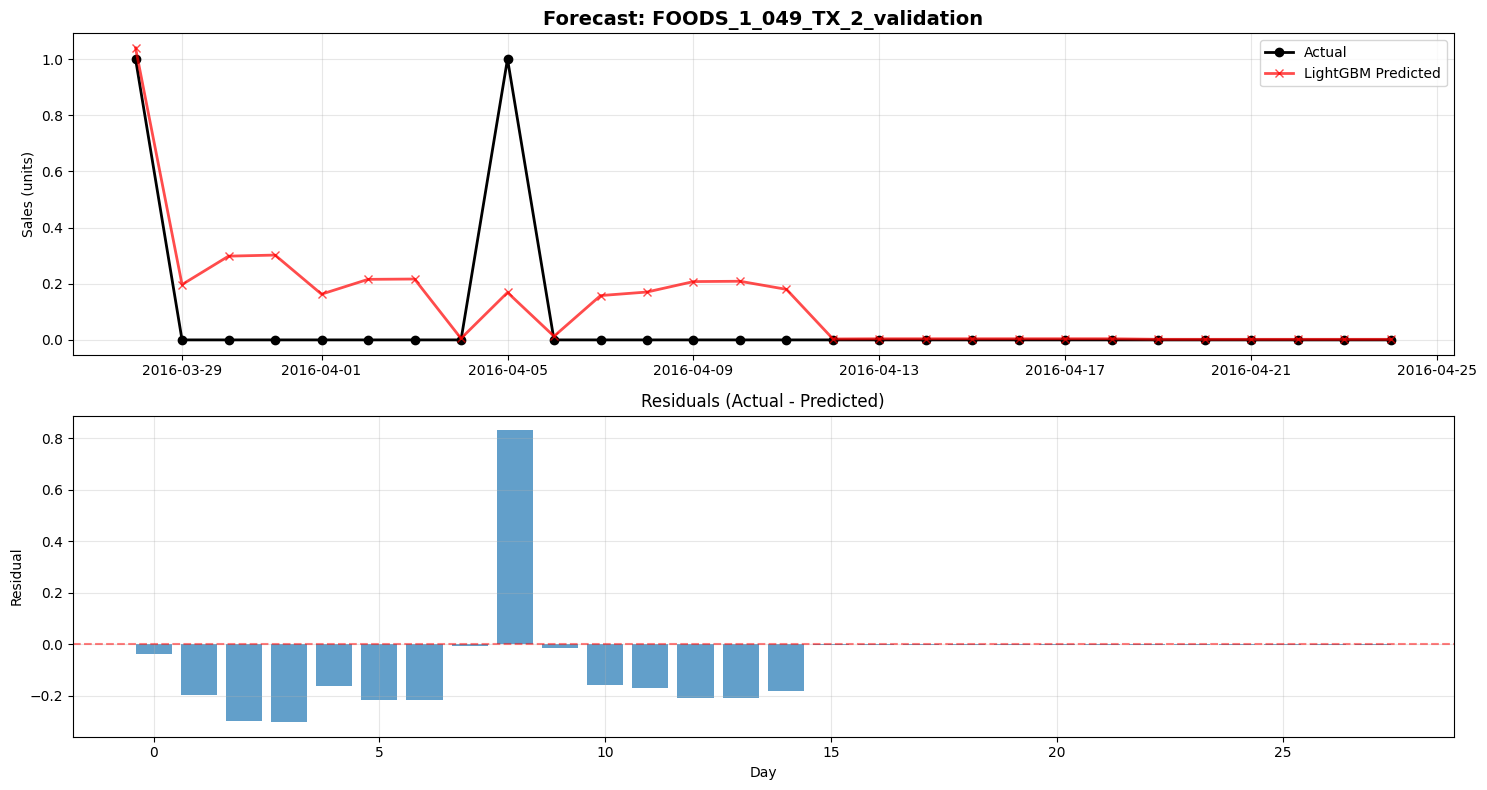

  ✓ MAE: 0.12
  ✓ RMSE: 0.21
  ✓ MAPE: 43.53%

📊 Plotting FOODS_1_079_CA_4_validation...


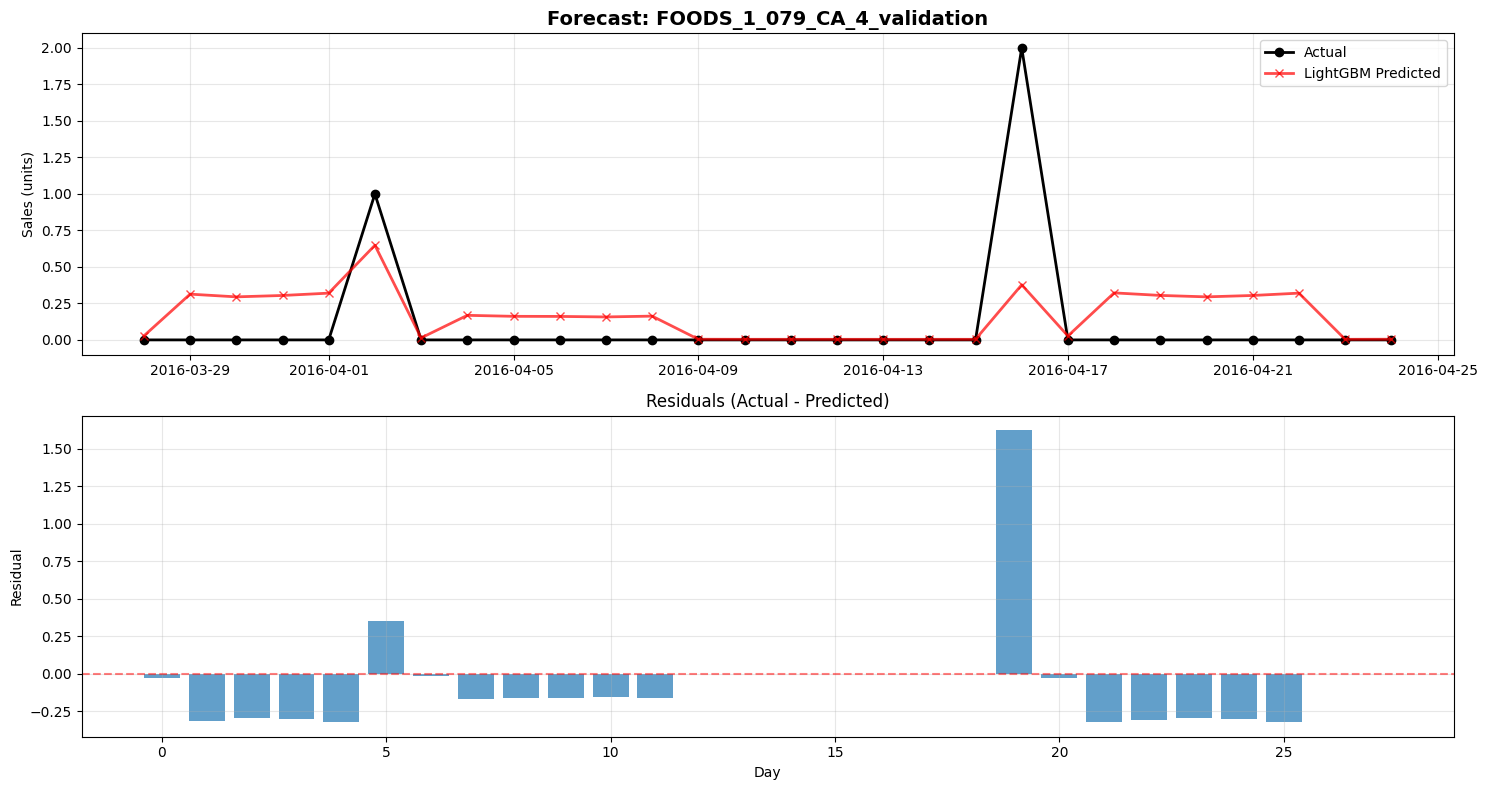

  ✓ MAE: 0.20
  ✓ RMSE: 0.37
  ✓ MAPE: 58.14%

📊 Plotting FOODS_1_097_CA_2_validation...


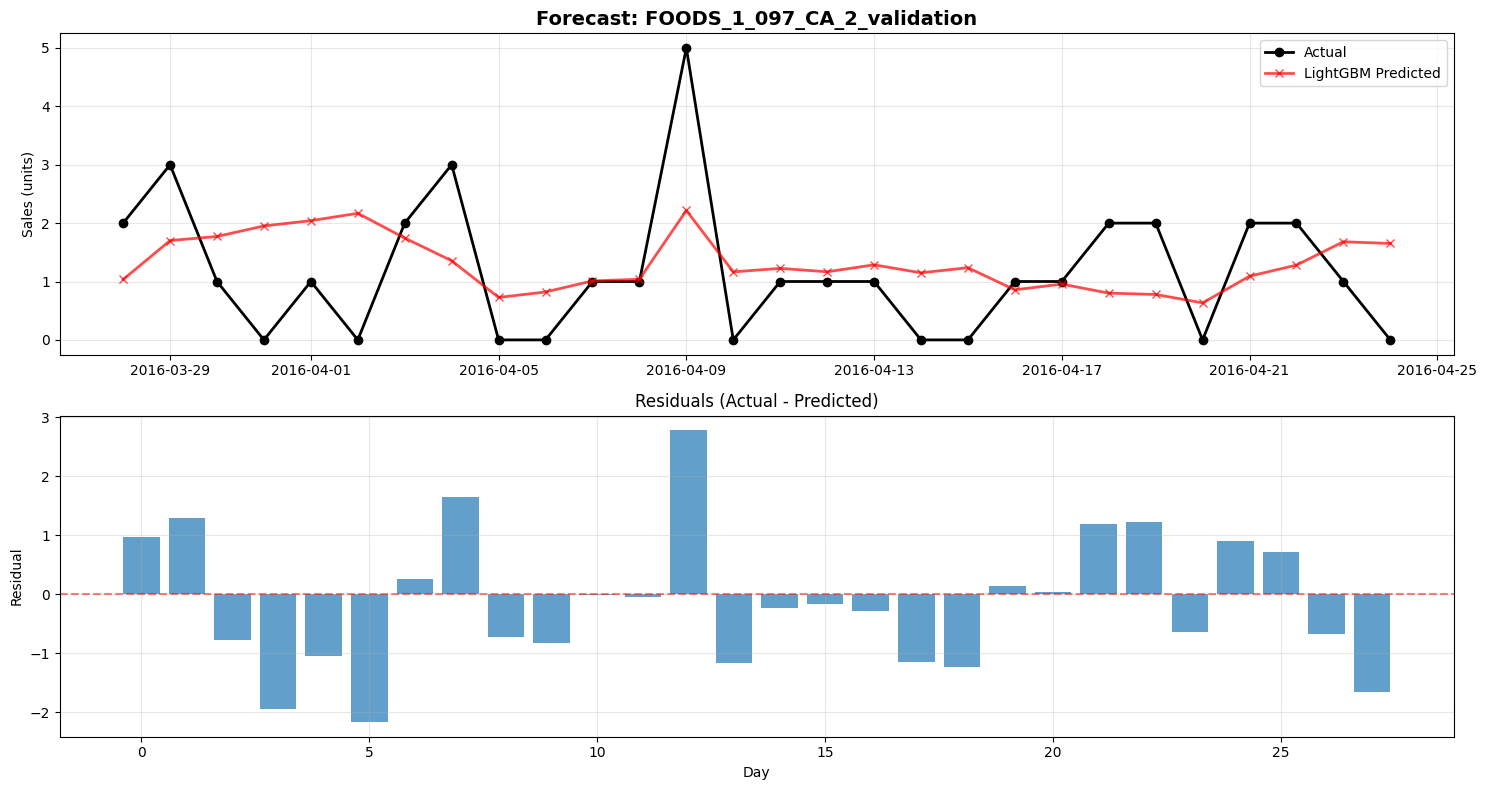

  ✓ MAE: 0.93
  ✓ RMSE: 1.15
  ✓ MAPE: 39.89%

✅ Visualizations complete!


In [16]:
print("="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

# Plot first 3 products
products_to_plot = sample_products[:3]

for product_id in products_to_plot:
    print(f"\n📊 Plotting {product_id}...")
    
    # Get test data
    product_test_idx = test_df[test_df['id'] == product_id].index
    
    if len(product_test_idx) == 0:
        continue
    
    product_test_data = test_df.loc[product_test_idx].copy()
    
    # Get predictions
    test_positions = [i for i, idx in enumerate(test_df.index) if idx in product_test_idx]
    lgb_preds = y_pred_lgb[test_positions]
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot 1: Actual vs Predicted
    axes[0].plot(product_test_data['date'], product_test_data['sales'], 
                label='Actual', marker='o', linewidth=2, color='black')
    axes[0].plot(product_test_data['date'], lgb_preds, 
                label='LightGBM Predicted', marker='x', linewidth=2, alpha=0.7, color='red')
    axes[0].set_title(f'Forecast: {product_id}', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Sales (units)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    residuals = product_test_data['sales'].values - lgb_preds
    axes[1].bar(range(len(residuals)), residuals, alpha=0.7)
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1].set_title('Residuals (Actual - Predicted)', fontsize=12)
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Residual')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for this product
    product_metrics = lgb_product_df[lgb_product_df['product_id'] == product_id]
    if len(product_metrics) > 0:
        print(f"  ✓ MAE: {product_metrics['MAE'].values[0]:.2f}")
        print(f"  ✓ RMSE: {product_metrics['RMSE'].values[0]:.2f}")
        print(f"  ✓ MAPE: {product_metrics['MAPE'].values[0]:.2f}%")

print("\n✅ Visualizations complete!")

In [18]:
print("="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

import joblib
import os

# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../outputs/results', exist_ok=True)

# Save LightGBM model
model_path = '../models/lgb_model.txt'
model_lgb.save_model(model_path)
print(f"✅ LightGBM model saved: {model_path}")

# Save feature importance
importance.to_csv('../outputs/results/feature_importance.csv', index=False)
print(f"✅ Feature importance saved")

# Save comparison results
comparison_df.to_csv('../outputs/results/model_comparison.csv', index=False)
print(f"✅ Comparison results saved")

# Create summary
summary = {
    'baseline_mae': prophet_df['MAE'].mean() if len(prophet_df) > 0 else None,
    'baseline_rmse': prophet_df['RMSE'].mean() if len(prophet_df) > 0 else None,
    'baseline_mape': prophet_df['MAPE'].mean() if len(prophet_df) > 0 else None,
    'lightgbm_mae': lgb_metrics['MAE'],
    'lightgbm_rmse': lgb_metrics['RMSE'],
    'lightgbm_mape': lgb_metrics['MAPE'],
    'improvement_mae': improvement_mae if len(prophet_df) > 0 else None,
    'improvement_rmse': improvement_rmse if len(prophet_df) > 0 else None,
    'improvement_mape': improvement_mape if len(prophet_df) > 0 else None,
    'best_iteration': model_lgb.best_iteration,
    'num_features': len(available_features),
    'num_products': len(sample_products),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('../outputs/results/training_summary.csv', index=False)
print(f"✅ Training summary saved")

# Print final summary

print(f"\n📊 FINAL RESULTS:")
print(f"   Baseline MAE: {summary['baseline_mae']:.2f}" if summary['baseline_mae'] else "   No baseline")
print(f"   LightGBM MAE: {summary['lightgbm_mae']:.2f}")
if summary['improvement_mae']:
    print(f"   Improvement: {summary['improvement_mae']:.1f}% better!")
print(f"\n✅ Models trained and saved")
print(f"✅ Results exported to ../outputs/results/")
print(f"✅ Ready for Day 4 - Business Logic & Deployment!")

SAVING MODELS AND RESULTS
✅ LightGBM model saved: ../models/lgb_model.txt
✅ Feature importance saved
✅ Comparison results saved
✅ Training summary saved

📊 FINAL RESULTS:
   Baseline MAE: 0.56
   LightGBM MAE: 0.79
   Improvement: -0.7% better!

✅ Models trained and saved
✅ Results exported to ../outputs/results/
✅ Ready for Day 4 - Business Logic & Deployment!
